In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...

import pymrio
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import operator

In [3]:
path_io = '/media/adrien/dd/adrien/DD/Économie/Données/'
# path_io = '/media/sf_U_DRIVE/Données/'
path_exio = path_io + 'Exiobase 2.2/'

In [4]:
path_pxp = path_exio+'mrIOT_PxP_ita_coefficient_version2.2.2.zip'
exio2p = pymrio.parse_exiobase2(path=path_pxp, charact=True, popvector='exio2')
exio2p.calc_all()
exio2p.y = np.sum(exio2p.Y, axis=1)
# exio2i = pymrio.parse_exiobase2(path=path_exio+'mrIOT_IxI_fpa_coefficient_version2.2.2.zip', charact=True, popvector='exio2')

In [42]:
## SECTORS BUNDLES
reg = reg_ref = 'FR'
regs = regs_ref = ['FR', 'AT']
sec= 'Wheat'
secs = ['Pigs', 'Wheat']

sectors = np.array(exio2p.get_sectors()) # list(exio2p.get_sectors())
regions = list(exio2p.get_regions())
nb_sectors = len(sectors)
nb_regions = len(regions)

# The only domains whose value can be negative in Y are 'Changes in inventories' and 'Changes in valuables'
#   stable_domain are the other ones, and are less prone to 2007-specific values
stable_domain = ['Final consumption expenditure by government', 'Gross fixed capital formation', 'Export', \
    'Final consumption expenditure by non-profit organisations serving households (NPISH)', \
    'Final consumption expenditure by households']
oil_primary = ['Crude petroleum and services related to crude oil extraction, excluding surveying']
secondary_oil_sectors = ['Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Kerosene Type Jet Fuel', \
               'Liquefied Petroleum Gases (LPG)', 'Naphtha', 'Non-specified Petroleum Products', 'Kerosene', \
               'Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
oil_sectors = oil_primary + secondary_oil_sectors
primary_coal_sectors = ['Other Bituminous Coal', 'Coking Coal',  'Lignite/Brown Coal', 'Sub-Bituminous Coal', 'Anthracite']
secondary_coal_sectors = ['Coke Oven Coke', 'Coal Tar', 'Coke oven gas']
coal_sectors = primary_coal_sectors + secondary_coal_sectors
primary_wo_oil = primary_coal_sectors + ['Natural gas and services related to natural gas extraction, excluding surveying', \
            'Nuclear fuel', 'Biogas', 'Biodiesels', 'Natural Gas Liquids', \
     'Charcoal', 'Ethane', 'Gas Coke', 'Gas Works Gas', 'Other Hydrocarbons', 'Other Liquid Biofuels']
primary_energy_sectors=primary_wo_oil+['Crude petroleum and services related to crude oil extraction, excluding surveying']
renewable_wo_hydro = ['Electricity by wind', 'Electricity by biomass and waste', 'Electricity by tide, wave, ocean', 'Electricity by Geothermal', \
                     'Electricity by solar photovoltaic', 'Electricity by solar thermal'] 
renewable_sectors = ['Electricity by hydro'] + renewable_wo_hydro
elec_hydrocarbon = ['Electricity by coal', 'Electricity by gas', 'Electricity by petroleum and other oil derivatives']
final_energy_sectors = ['Steam and hot water supply services', 'Electricity by nuclear', 'Electricity nec'] + elec_hydrocarbon
secondary_energy = secondary_oil_sectors + secondary_coal_sectors
secondary_energy_sectors = primary_wo_oil + secondary_oil_sectors
new_secondary_energy_sectors = renewable_sectors + final_energy_sectors + secondary_oil_sectors
primary_fuels = np.unique(primary_coal_sectors + primary_energy_sectors)
fuels = np.unique(list(primary_fuels) + ['Heavy Fuel Oil', 'Liquefied Petroleum Gases (LPG)'] + coal_sectors + \
                  oil_sectors + ['Natural gas and services related to natural gas extraction, excluding surveying'])
other_energy_sectors = ['Distribution services of gaseous fuels through mains', 'Refinery Feedstocks', \
                        'Blast Furnace Gas', 'Oxygen Steel Furnace Gas', # TODO: check it should be here
                        'Distribution and trade services of electricity', 'Refinery Gas', 'Uranium and thorium ores', \
                    'Transmission services of electricity', 'Biogasoline', 'Patent Fuel', 'BKB/Peat Briquettes', 'Peat']
energy_sectors = primary_energy_sectors + secondary_energy + final_energy_sectors + renewable_sectors + other_energy_sectors
# /!\ waste (incineration) and some gas sectors missing (TODO)
sources = ['elec_coal', 'elec_oil', 'elec_gas', 'elec_nuclear', 'wind', 'PV', 'hydro', 'nuclear_fuel', \
           'coal', 'gas_extraction', 'oil_extraction',]

metal_sectors = ['Iron ores', 'Copper ores and concentrates', 'Nickel ores and concentrates',
       'Aluminium ores and concentrates', 'Precious metal ores and concentrates', 'Lead, zinc and tin ores and concentrates',
       'Other non-ferrous metal ores and concentrates']
non_metallous_minerals = ['Stone', 'Sand and clay', 
                          'Chemical and fertilizer minerals, salt and other mining and quarrying products n.e.c.']
raw_minerals = metal_sectors + non_metallous_minerals
minerals_secondary = ['Bricks, tiles and construction products, in baked clay', 'Cement, lime and plaster', 
        'Ash for treatment, Re-processing of ash into clinker', 'Other non-metallic mineral products', 
        'Rubber and plastic products', 'Glass and glass products', 
        'Secondary glass for treatment, Re-processing of secondary glass into new glass', 'Ceramic goods']
metals_secondary = [ 'Basic iron and steel and of ferro-alloys and first products thereof',
       'Secondary steel for treatment, Re-processing of secondary steel into new steel', 'Precious metals',
       'Secondary preciuos metals for treatment, Re-processing of secondary preciuos metals into new preciuos metals',
       'Aluminium and aluminium products', 'Lead, zinc and tin and products thereof',
    'Secondary aluminium for treatment, Re-processing of secondary aluminium into new aluminium',
       'Secondary lead for treatment, Re-processing of secondary lead into new lead',
       'Copper products', 'Secondary copper for treatment, Re-processing of secondary copper into new copper',
       'Other non-ferrous metal products', 'Secondary other non-ferrous metals for treatment, \
Re-processing of secondary other non-ferrous metals into new other non-ferrous metals',]
materials = ['Secondary raw materials'] + raw_minerals + minerals_secondary + metals_secondary
materials_and_energy = materials + primary_energy_sectors
food = ['Paddy rice', 'Wheat', 'Cereal grains nec', 'Vegetables, fruit, nuts', 'Oil seeds', 'Sugar cane, sugar beet',
    'Plant-based fibers', 'Crops nec', 'Cattle', 'Pigs', 'Poultry', 'Meat animals nec', 'Animal products nec', 'Raw milk',
       'Fish and other fishing products; services incidental of fishing']
agriculture_forest_wo_food = ['Wool, silk-worm cocoons', 'Manure (conventional treatment)', 'Pulp',
       'Manure (biogas treatment)', 'Products of forestry, logging and related services']
processed_food = ['Products of meat cattle', 'Products of meat pigs', 'Products of meat poultry', 'Meat products nec',
       'products of Vegetable oils and fats', 'Dairy products', 'Processed rice', 'Sugar', 'Food products nec', 
        'Beverages', 'Fish products']
processed_agri_forest = ['Tobacco products', 'Textiles', 'Wearing apparel; furs', 'Leather and leather products',
       'Wood and products of wood and cork (except furniture); articles of straw and plaiting materials',
       'Wood material for treatment, Re-processing of secondary wood material into new wood material', 'Printed matter and recorded media',
       'Secondary paper for treatment, Re-processing of secondary paper into new pulp', 'Paper and paper products']
chemicals_plastics = ['White Spirit & SBP', 'Lubricants', 'Bitumen', 'Paraffin Waxes', 'Plastics, basic', 'Additives/Blending Components',
       'Secondary plastic for treatment, Re-processing of secondary plastic into new plastic', 'N-fertiliser', 'P- and other fertiliser', 'Chemicals nec']
# TODO: /!\ Bitumen in plastics ?
heavy_industry = ['Foundry work services', 'Fabricated metal products, except machinery and equipment']
electr_on_ical = ['Machinery and equipment n.e.c.', 'Office machinery and computers', 'Electrical machinery and apparatus n.e.c.',
       'Radio, television and communication equipment and apparatus', 'Medical, precision and optical instruments, watches and clocks']
other_industry = ['Motor vehicles, trailers and semi-trailers', 'Bottles for treatment, Recycling of bottles by direct reuse',
       'Other transport equipment', 'Furniture; other manufactured goods n.e.c.', 'Collected and purified water, distribution services of water']
agribusiness = food + agriculture_forest_wo_food + processed_food + processed_agri_forest
industry = chemicals_plastics + heavy_industry + electr_on_ical + other_industry
construction = ['Construction work',
       'Secondary construction material for treatment, Re-processing of secondary construction material into aggregates']
services = ['Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries',
       'Retail trade services of motor fuel', 'Wholesale trade and commission trade services, except of motor vehicles and motorcycles',
       'Retail  trade services, except of motor vehicles and motorcycles; repair services of personal and household goods',
       'Hotel and restaurant services', 'Railway transportation services', 'Other land transportation services', 'Transportation services via pipelines',
       'Sea and coastal water transportation services', 'Inland water transportation services', 'Air transport services',
       'Supporting and auxiliary transport services; travel agency services', 'Post and telecommunication services',
       'Financial intermediation services, except insurance and pension funding services', 
       'Insurance and pension funding services, except compulsory social security services', 'Services auxiliary to financial intermediation',
       'Real estate services', 'Renting services of machinery and equipment without operator and of personal and household goods',
       'Computer and related services', 'Research and development services', 'Other business services',
       'Public administration and defence services; compulsory social security services', 'Education services', 'Health and social work services', 
        'Membership organisation services n.e.c.', 'Recreational, cultural and sporting services', 'Other services',
       'Private households with employed persons', 'Extra-territorial organizations and bodies']
waste_landfill = ['Food waste for treatment: incineration', 'Paper waste for treatment: incineration', 'Plastic waste for treatment: incineration', 
        'Intert/metal waste for treatment: incineration', 'Textiles waste for treatment: incineration', 'Wood waste for treatment: incineration',
       'Oil/hazardous waste for treatment: incineration', 'Food waste for treatment: biogasification and land application',
       'Paper waste for treatment: biogasification and land application', 'Sewage sludge for treatment: biogasification and land application',
       'Food waste for treatment: composting and land application', 'Paper and wood waste for treatment: composting and land application',
       'Food waste for treatment: waste water treatment', 'Other waste for treatment: waste water treatment', 'Food waste for treatment: landfill',
       'Paper for treatment: landfill', 'Plastic waste for treatment: landfill', 'Inert/metal/hazardous waste for treatment: landfill',
       'Textiles waste for treatment: landfill', 'Wood waste for treatment: landfill']
cars = ['Motor vehicles, trailers and semi-trailers']

partition_sectors = {'energy': energy_sectors, 'materials': materials, 'agribusiness': agribusiness, 'industry': industry, 
                     'construction': construction, 'services': services, 'waste': waste_landfill}
composition_sectors = {'energy': primary_energy_sectors, 'materials': materials, 'agribusiness': agribusiness, 'industry': industry, 
                     'construction': construction, 'services': services, 'waste': waste_landfill}
decomposition_sectors  = {'energy': primary_energy_sectors, 'materials': materials, 'agribusiness': agribusiness, 'chemicals, plastics': chemicals_plastics, 
    'heavy industry': heavy_industry,
  'electric, electronic industry': electr_on_ical, 'other industry': other_industry + waste_landfill, 'construction': construction, 'services': services}

def sectors_source(source): 
    if source=='all': return(sectors)
    elif source=='fuels' or source=='fuel': return(fuels)
    elif source=='new_secondary_fuels': return(inter_secs(fuels, new_secondary_energy_sectors))
    elif source=='primary': return(primary_energy_sectors)
    elif source=='secondary': return(secondary_energy_sectors)
    elif source=='new_secondary': return(new_secondary_energy_sectors)
    elif source=='final': return(final_energy_sectors)
    elif source=='secondary&final': return(secondary_energy_sectors+final_energy_sectors)
    elif source=='nuclear_fuel': return('Nuclear fuel')
    elif source=='hydro': return('Electricity by hydro')
    elif source=='PV': return('Electricity by solar photovoltaic')
    elif source=='wind': return('Electricity by wind')
    elif source=='oil_extraction' or source=='oil': 
        return('Crude petroleum and services related to crude oil extraction, excluding surveying')
    elif source=='gas_extraction' or source=='gas': 
        return('Natural gas and services related to natural gas extraction, excluding surveying')
    elif source=='oil_secondary': return(secondary_oil_sectors)
    elif source=='coal': return(coal_sectors)
    elif source=='oil_and_gas': return(['Crude petroleum and services related to crude oil extraction, excluding surveying', \
                                        'Natural gas and services related to natural gas extraction, excluding surveying'])
    elif source=='elec_gas': return('Electricity by gas')
    elif source=='elec_oil': return('Electricity by petroleum and other oil derivatives')
    elif source=='elec_coal': return('Electricity by coal')
    elif source=='elec_nuclear': return('Electricity by nuclear')
    else: print("source not known (you may add it to the function 'sectors')")

In [59]:
## NAMES IMPACTS (OR SECTORS)
def name_var(var):
    if var=='hours' or var=='hour' or var=='Employment hour': return('Employment hour')
    elif var=='employment' or var=='empl' or var=='labor' or var=='Employment': return('Employment')
    elif var=='energy' or var=='Total Energy Use' or var=='use': return('Total Energy Use')
    elif var=='Total Energy supply' or var=='energy supply' or var=='supply': return('Total Energy supply')
    elif var=='Total Energy inputs from nature': return('Total Energy inputs from nature')
    elif var=='Total Emission relevant energy use': return('Total Emission relevant energy use')
    elif var=='warming' or var=='global warming': return('global warming (GWP100)')
    else: return('unknown')
    
def find(string, vec='impacts'): # Find vec=impacts/sectors containing string
    if vec=='impacts' or vec=='Impacts' or vec=='impact': array = np.array(exio2p.impact.unit.iloc[:,0].index)
    elif vec=='sectors': array = np.array(sectors)
    return(array[np.where(list(map(lambda s: string in s, array)))[0]])

## GENERIC FUNCTIONS
def div0(a, b): return(np.divide(a, b, out=np.zeros_like(a), where=b!=0))
def sorted_series(series): return(sorted(series.items(), reverse=True, key=operator.itemgetter(1)))
def sorted_array(array, index=exio2p.x.index, group_by=None): 
    if group_by is None: return(sorted_series(pd.Series(array, index=index)))
    else: return(sorted_series(pd.Series(array, index=index).groupby(group_by).sum()))
def inter_secs(secs1, secs2): return(list(np.array(secs1)[np.where([sec in secs2 for sec in secs1])[0]]))

## INDEXES
# /!\ Python sorts regs and secs before applying the function
def index_regs(regs): return(np.where(list(map(lambda r: r in regs, regions)))[0]) # for list of str
def index_secs(secs): return(np.where(list(map(lambda s: s in secs, sectors)))[0]) # indexes of a list of sectors
def index_regs_secs(regs=regions, secs=sectors):  # all combinations of indexes
    return(np.repeat(index_regs(regs)*nb_sectors, len(secs)*(type(secs)!=str)+(type(secs)==str)) \
           + np.tile(index_secs(secs), len(regs)*(type(regs)!=str)+(type(regs)==str)) )

## BASIC STATISTICS
def final_demand(secs=sectors, regs=regions): 
    indexes = index_regs_secs(regs, secs)
    return(exio2p.Y[[(reg,dom) for reg in regions for dom in stable_domain]].sum(axis='columns')*list(map(lambda i: i in indexes, range(nb_regions*nb_sectors))))

def production(secs=sectors, regs=regions): return(exio2p.x*list(map(lambda i: i in index_regs_secs(regs, secs), range(nb_regions*nb_sectors))))
    
def impact(var, regs=regions, secs=sectors, join_sort=False):
    if type(regs)==str: regs=[regs]
    if var=='unknown': var='Value Added'
    if join_sort: return(sorted_series(exio2p.impact.F.loc[var].loc[regs,secs].groupby('sector').sum()))
    else: return(exio2p.impact.F.loc[var].loc[regs,secs])
    
def embodied_prod(secs=sectors, regs=regions): return(np.dot(exio2p.L, production(secs, regs)))
# Embodied energy for a sec-regs. Notion: use, supply or used (=use-supply) / source: primary, secondary, all
def embodied_impact(secs='Electricity by solar photovoltaic', regs=regions, notion='supply', source=sectors, netting_fuel = False, group_by='region', sort=False):
    share_demand = div0(embodied_prod(secs, regs)-production(secs, regs), exio2p.x)
    energy = impact(name_var(notion))*share_demand
    energy = energy[index_regs_secs(regions, source)]
    if sort: return(sorted_series(energy.groupby(group_by).sum()))
    else: return(energy.groupby(group_by).sum())    
        
# Traverse value chain backwards from regs-secs. group_by: None, sector, region / nb_main: number or 'all
def inputs(secs=sectors, regs=regions, var_impacts=[], source='all', order_recursion=4, nb_main=5, group_by='sector'): 
    if nb_main=='all': nb_main==nb_sectors*nb_regions
    if type(var_impacts)==str: var_impacts = [var_impacts]
    nb_var = len(var_impacts)
    demand = [None for i in range(order_recursion)]
    impacts = [[None for i in range(order_recursion)] for j in range(nb_var)]
    sums = [[] for i in range(nb_var+1)]
#     demand[0] = final_demand(secs, regs)
    demand[0] = production(secs, regs)
    for i in range(0, order_recursion):
        if nb_var>0: share_demand_i = div0(demand[i], exio2p.x)
        for l in range(0, nb_var): 
            impacts_l_i = impact(var_impacts[l])*share_demand_i
            impacts[l][i] = impacts_l_i[index_regs_secs(regions, sectors_source(source))]
            sums[l].append(impacts[l][i].sum())
        if i+1<order_recursion: demand[i+1] = np.dot(exio2p.A, demand[i])
        sums[nb_var].append(demand[i].sum())
    for k in range(0, nb_var): impacts[k] = list(map(lambda j: sorted_array(j, group_by=group_by)[0:nb_main],impacts[k]))
    demand = list(map(lambda j: sorted_array(j, group_by=group_by)[0:nb_main], demand))
    return((impacts, demand, sums))

def outputs(secs=sectors, out_sectors=sectors, nb_main=5):
    production = exio2p.x.iloc[index_regs_secs(regions, secs)].sum()
    return((exio2p.y.iloc[index_regs_secs(regions, secs)].sum()/production, \
            sorted_series(exio2p.Z.iloc[index_regs_secs(regions, secs)].sum().groupby('sector').sum()[out_sectors]/production)[0:nb_main]))

def eroi(secs='Electricity by solar photovoltaic', regs=regions, notion='supply', source='new_secondary', netting_fuel = True):
    supply = impact(name_var('supply'), regs, secs).sum()
    embodied = embodied_impact(secs, regs, notion, sectors_source(source)).sum()
    if ((type(secs)==str and secs in elec_hydrocarbon) or secs==elec_hydrocarbon) and netting_fuel: 
        input_fuel = inputs(secs, var_impacts=[name_var('supply')], source='new_secondary_fuels', order_recursion=2)[2][0][1]
    else: input_fuel = 0 # We want to include fuels that are used for transportation, not transformed into electricity (this is not secondary anymore)
    return(supply/(embodied - input_fuel))

def erois(notion='supply', source='new_secondary', external=False, display=True, netting_fuel=True):
    erois = []
    if display: 
        print(external*'External '+'EROI with '+notion+' from '+source+' sources at the denominator, unadjusted for growth')
    for secs in sources: 
        eroi_secs = eroi(sectors_source(secs), regions, notion, source, netting_fuel) # eroi(sectors_source(secs), regions, notion, source, external)
        erois.append(eroi_secs)
        if display: print(secs, eroi_secs)
    return(erois)

def composition_impact(sec, impact=name_var('use'), partition_sectors=composition_sectors, sort=True):
    impact_sectors = {}
    sectors_tot = sum([[s for s in partition_sectors[sec]] for sec in partition_sectors], [])
    impacts_tot = embodied_impact(sec, source=sectors_tot, notion=impact).sum()
    for sectors_i_name, sectors_i in partition_sectors.items():
        impact_sectors[sectors_i_name] = embodied_impact(sec, source=sectors_i, notion=impact).sum()/impacts_tot
    if sort: return(sorted(impact_sectors.items(), reverse=True, key=operator.itemgetter(1)))
    else: return(impact_sectors)
    
def composition_impacts(sec, impacts=[name_var('use'), name_var('supply'), name_var('warming')], partition_sectors=decomposition_sectors, sort=True):
    impacts_sectors = {}
    for impact in impacts:
        impacts_sectors[impact] = composition_impact(sec, impact, partition_sectors, sort)
    print(sec)
    return(impacts_sectors)

def total_consumption(secs, add=True):
    if add: return(exio2p.x.iloc[index_regs_secs(regions, secs)].groupby('sector').sum())
    else: return(exio2p.x.iloc[index_regs_secs(regions, secs)].groupby('sector').sum().groupby('region').sum()) # works  only for type(secs)==str
    
# J from * $ to / ($ from / J to) = J/$ from/to
def conversion_price(to = sectors_source('wind'), froms = elec_hydrocarbon, var = name_var('supply')):
    return(impact(var, regions, froms).groupby('sector').sum()*total_consumption(to)[0]/\
           (total_consumption(froms)*impact(var, regions, to).groupby('sector').sum()[0]))

def cleaner(share_PV = 0.5, share_wind = 0.5, replaced = elec_hydrocarbon): # returns an IOsystem with only renewable electricity
    cleaner = exio2p.copy()
    cleaner.Y.iloc[index_regs_secs(regions, sectors_source('wind'))] += share_wind * np.kron(np.eye(nb_regions), \
                                np.array(conversion_price(sectors_source('wind')))) @ exio2p.Y.iloc[index_regs_secs(regions, replaced)]
    cleaner.Y.iloc[index_regs_secs(regions, sectors_source('PV'))] += share_PV * np.kron(np.eye(nb_regions), \
        np.array(conversion_price(sectors_source('PV')))) @ exio2p.Y.iloc[index_regs_secs(regions, replaced)]
    cleaner.Y.iloc[index_regs_secs(regions, replaced)] = 0
    cleaner.y = np.sum(cleaner.Y, axis=1)
    # in the following, we assume a global elec grid providing the same elec for all sectors, replacing the 'replaced' sectors
    global_conversion = np.tile(np.stack(([i==index_secs(sectors_source('PV'))[0] for i in \
                range(nb_sectors)],[i==index_secs(sectors_source('wind'))[0] for i in range(nb_sectors)]),axis=1) \
             @ np.array([share_PV*conversion_price(sectors_source('PV')),share_wind*conversion_price(sectors_source('wind'))]), nb_regions)
    national_weights = [[exio2p.x.loc[(reg, sectors_source('PV'))]] for reg in regions]/production(secs=sectors_source('PV')).sum()
    cleaner.A[[(reg, sec) for reg in regions for sec in replaced]] = np.kron(national_weights, global_conversion)
    cleaner.L = pd.DataFrame(np.linalg.inv(np.eye(cleaner.A.shape[0])-cleaner.A), index=cleaner.A.index, columns=cleaner.A.columns)
    cleaner.x = pd.Series(np.array(cleaner.L) @ np.array(cleaner.y), index=cleaner.x.index)
    cleaner.Z = pd.DataFrame(np.array(cleaner.A) @ np.diag(np.array(cleaner.x)), index=cleaner.Z.index, columns=cleaner.Z.columns)
    cleaner.impact.S.loc[[name_var(var) for var in ('use', 'supply')], [(reg, sec) for reg in regions for sec in replaced]] = 0
    cleaner.impact.F = pd.DataFrame(cleaner.impact.S @ np.diag(cleaner.x), index=cleaner.impact.F.index, columns=cleaner.impact.F.columns)
    return(cleaner)

In [55]:
## EROIS
# primary, supply, external, elec (Netting energy_fuel for...). old benchmark. Low elec_oil, hydro, elec_nuclear and to a lesser extent elec_coal and elec_gas.
# primary, supply, internal, elec. Low for hydrocarbon; for the rest, similar to external=True
# primary, supply, internal, all. :) Higher for fuels. Seems good
# primary, supply, external, all. /!\ Negative values for coal and gas_extr.
# primary, supply, external, none. /!\ Values < 1 for elec_hydrocarbon.
# primary, supply, internal, none. /!\ Values < 1 for elec_hydrocarbon.
# new_secondary, supply, external, none. /!\ elec_oil = 1, Negative values for  hydrocarbon.
# new_secondary, supply, internal, none. /!\ elec_oil = 1. Rest is ok but elec_hydrocarbon = renewable.
# new_secondary, supply, internal, all. /!\ Negative values for elec_hydrocarbon, PV and hydrcarbon. wind=84
# new_secondary, supply, external, all. /!\ Negative values for elec_hydrocarbon, PV and hydrcarbon. wind=92
#>new_secondary, supply, internal, none, netting_fuel. :) Low values for elec_hydrocarbon, especially elec_oil (6)
# new_secondary, use, internal, none, netting_fuel. Low values for elec_hydrocarbon, especially elec_oil (4)
# new_secondary, use, internal, none, no netting_fuel. /!\ Low values for elec_hydrocarbon, especially elec_oil (1)
erois() # the one which is '>', BENCHMARK

# Idéalement, il faudrait construire une matrice I-O de flux d'énergie (au lieu de monétaire) et couper le lien entre fuel et élec par fuel (=>0)
# En première approximation, je coupe juste le lien de premier ordre.

External EROI with supply from new_secondary sources at the denominator, unadjusted for growth
elec_coal 14.946645524909561
elec_oil 6.1816758147694975
elec_gas 13.569437319398288
elec_nuclear 23.556439840069093
wind 14.256776829645599
PV 9.980225308320374
hydro 16.777785590042914
nuclear_fuel 115.16751169197461
coal 68.2588985784022
gas_extraction 61.201766638401516
oil_extraction 28.251863529097964


[14.946645524909561,
 6.1816758147694975,
 13.569437319398288,
 23.556439840069093,
 14.256776829645599,
 9.980225308320374,
 16.777785590042914,
 115.16751169197461,
 68.2588985784022,
 61.201766638401516,
 28.251863529097964]

In [60]:
eroi2(elec_hydrocarbon)

13.36317169995672

In [61]:
exio2p_true = exio2p
exio2p = cleaner()

In [23]:
# exio2p = exio2p_true

In [ ]:
cleaner = exio2p

In [62]:
erois = erois() # from cleaner

External EROI with supply from primary sources at the denominator, unadjusted for growth
elec_coal 0.0
elec_oil 0.0
elec_gas 0.0
elec_nuclear 11.00027862738173
wind 7.407727635197864
PV 5.572398556231152
hydro 10.005944719322763
nuclear_fuel 87.27494526530018
coal 4.550729396940454
gas_extraction 15.773882468783828
oil_extraction 13.273277408959808


In [39]:
## CORRECT EROI FOR GROWTH OF SECTOR
# Two effects: 1. With constant current production, if production lifetime ago was below, the replacement is below what would be needed in 
#   a steady-state => over-estimation of the EROI of conventional energies ; 2. With growing capacity, inputs used now will produce more 
#   than current capacity => under-estimation of the EROI of renewables. (For nuclear, don't know the direction of the bias).
# Pb: the same effects work also higher in the value chain, as capital and intermediary inputs are not distinguished in the IOT.
# To correct the bias: find the prod capacity being built in 2007. 1. For conventionals, can be done by looking at production 'lifetime' ago
#    2. For renewables, can be done by looking at the production 'construction duration' years after,
#   Then multiply the EROI by the ratio of production capacity being built over current production.
# 1.a Lifetimes from LiVES: combustion furnaces: 20 yrs; Other general industrial machinery and equipment: 16 y; Other industrial heavy electrical equipment: 22y;
#      Other electric systems: 16y; Oil/gas tank facilities and pipelines: 30y
# 1.b    from Neumeyer and Goldston 2016 (nose-guess): 40y for coal, gas and nuclear, 70 for hydro
# 1.c    from Weissbach 2013 (sourced): 50y for coal, 35 for gas, 60 for nuclear, 100 for hydro
# 2.a Construction duration incl. network junction  for wind: 1-2 yrs renewablesfirst.co.uk/windpower/windpower-learning-centre/how-long-will-the-whole-project-take/
#         http://www.futuren-group.com/en/lenergie-eolienne/realisation-dun-projet-eolien
# 2.b PV: less than 1 year https://www.nrel.gov/docs/fy15osti/63556.pdf
# For nuclear, 2007 construction probably below the replacement of current production 
#     https://www.economist.com/graphic-detail/2017/01/30/construction-of-most-nuclear-power-reactors-is-behind-schedule
# ADJUSTED EROIS: (coal: 28; gas: 8.5; oil: 9; hydro: 5;) PV: 8; wind: 15-18
# /!\ The adjustment is valid iff the main energy use in the process takes place during the construction. It may be likely for renewables but not for conventionals,
#      also considering that EROI is decreasing for hydrocarbons, so current inputs for future prod may use as much energy as past inputs for current prod, even if
#      there is less construction than before.

# Energy supply roughly corresponds to BP statistical review figures:
impact(name_var('supply'), secs=sectors_source('oil'), join_sort=True)
538329/3600 # wind 150 TWh / BP: 170.8 (2008: 219.1, 2009: 277.9)
29751/3600 # PV 8 TWh / BP: 7.7 (2008: 12.6, 2009: 20.9)
9588615/3600 # hydro 2663 / BP: 3083.7 (1965: 920, 1970: 1175, 2008: 3267.1, 2009: 3255.7)
8975453/3600 # nuclear 2493 Twh / BP: 2746.5 (1970: 78.5, 1975: 433, 2008: 2737.9, 2009: 2712)
# coal 3607 Mtoe/ BP: 3480.2 (1965: 1404, 1670: 1483, 2008: 3528.4, 2009: 3476.1)  (107671926+16014799+15240445+3834569+3284409+2925042+1754264+302747)*2.3885e-5
96017879*2.3885e-5 # gas 2293 Mtoe / BP: 2678.1 (1970: 890, 2008: 2748, 2009: 2675.5)
151126662*2.3885e-5 # oil 3609 Mtoe / BP: 4041.9 (1970: 2253, 2008: 4025.3 2009: 3955.7) TJ to Mtoe: 2.3885e-5

In [44]:
## NOTES CECILIA:

# Weird/Questions:
# - Dans scenarios/electricitymixchange, à la ligne ~90, est-ce normal de ne pas ajuster pour les autres secteurs (est-ce fait ailleurs) ?
# - line 89 of step_2b/emissions_modifiers, pourquoi -0.8 ? est-ce que ça devrait pas être 0.2 ?

# Steps:
# ✓ run everything to check results are the same (and tests pass)
# - compute EROIs: in octave (from SUT) or in ipython (calculate IOT from SUT) => impossible from Cecilia at the moment because lack of energy supply data
# - find scenarios and assumptions
# - adapt Cecilia to Exiobase 2 (ou 3)
# - change step_2a/mix.txt, step_2b/technological_change.txt (done in CeciliaEurope...ods), step_2b/emission_modifiers.txt, step_3/consumption_change.txt
# - run Cecilia, export and compute EROIs

18.478823529411766

In [3]:
import numpy as np
a = np.array([[0,0],[1,1],[2,2]])
b, c = a.shape

In [8]:
import sympy as sym
sym.init_printing()

In [9]:
pv = sym.symbols('pv') # proportion of PV in energy mix
# m_pv (resp. m_oil) units of materials required for 1 kWh from PV (resp. oil)
m_pv, m_oil = 0.7, 0.1 # sym.symbols('m_pv m_oil') 
unit_energy_output = sym.Matrix([0, 0, 0, 1])
energy_mix = [pv, 1-pv] # proportion of [PV, oil]
A = sym.Matrix([[0, 0, m_pv, 0.1], [0, 0, m_oil, 0.1], [0, 0, 0.2, 0.5], energy_mix + [0, 0]]) # order of ligns/columns: PV, oil, materials, energy
L = sym.eye(4)-A # sym.Matrix(3,3,[1, -m, -1, 0, 0.8, -1, -e, 0, 1])
Linv = L.inv()
EROI = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(4)).dot(unit_energy_output)))
[round(EROI.subs(pv, PV),1) for PV in [0, 1]]

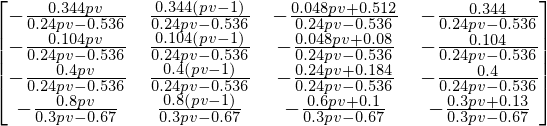

In [13]:
(EROI.subs(pv, 1)+EROI.subs(pv, 1))/2
1/(1/EROI.subs(pv, 0)+1/EROI.subs(pv, 1))
(EROI.subs(pv, 0)*EROI.subs(pv, 1))**0.5
EROI.subs(pv, 0.5)
sym.simplify(Linv-sym.eye(4))

In [12]:
(-0.3*0+0.67)/0.8
(-0.3*1+0.67)/0.8

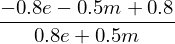

In [199]:
m, e = sym.symbols('m e') # m (resp. e) units of materials (resp. energy) required for 1 unit of energy technology (PV, oil...)
unit_energy_output = sym.Matrix([0, 0, 1])
unit_tech_output = sym.Matrix([1, 0, 0])
A = sym.Matrix([[0, m, e], [0, 0.2, 0.5], [1, 0, 0]])
L = sym.eye(3)-A # sym.Matrix(3,3,[1, -m, -1, 0, 0.8, -1, -e, 0, 1])
Linv = L.inv()
EROI = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(3)).dot(unit_energy_output)))
EROI

In [200]:
# values = [i/2+0.1 for i in range(2)] # [0.1, 0.6]
# sym.Matrix([[EROI.subs(e, E).subs(m, M) for E in values] for M in values]) # negative values correspond to divergent some of powered A: not physical/sustainable
[EROI.subs(e, 0.1).subs(m, M) for M in [0.1, 0.3, 0.5, 0.7]]

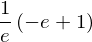

In [183]:
sym.init_printing()
m, e = sym.symbols('m e')
unit_energy_output = sym.Matrix([0, 1])
unit_tech_output = sym.Matrix([1,  0])
A = sym.Matrix([[0, e], [1, 0]])
L = sym.eye(2)-A # sym.Matrix(3,3,[1, -m, -1, 0, 0.8, -1, -e, 0, 1])
Linv = L.inv()
EROI = sym.simplify(1/unit_energy_output.transpose().dot((Linv-sym.eye(2)).dot(unit_energy_output)))
EROI # 1/e-1

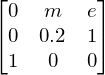

In [196]:
A